# Choropleth maps for the municipalities of Gran Canaria
Two main data files are needed:
1. A geoJSON file with the contours
2. A CSV file with the properties (area, coastline length, population).

In [7]:
import hikinggc
from importlib import reload
reload(hikinggc)

import os
import geojson
import glob
import json
import numpy as np
import shapely
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patheffects as path_effects

import pandas as pd
import cartopy.crs as ccrs
import cartopy.mpl.gridliner as gridliner
import logging

fontawesome, fontreg, fontbold = hikinggc.load_fonts()
plt.style.use("./hiking.mplstyle")

In [2]:
logger = logging.getLogger("populationCanary")
logger.setLevel(logging.INFO)
logging.info("")

## Files and directories

In [95]:
figdir = os.path.join(hikinggc.figdir, "maps/")
municipioscodefile = os.path.join(hikinggc.datadir, "municipios_codigos.csv") # https://datos.canarias.es/catalogos/estadisticas/dataset/municipios-canarias-2007-delimitaciones-territoriales-fines-estadisticos/resource/74237bc8-1e5f-43f1-9f6b-24ef9e073903
municipiosfile = os.path.join(hikinggc.datadir, "GCmunicipios.geojson")
propertyfile = os.path.join(hikinggc.datadir, "population_surface_grancanaria.csv")
os.path.isfile(municipiosfile) & os.path.isfile(propertyfile)

True

### Create dictonary [geocode → municipio name]

In [119]:
code_municipio_dict = {}
with open(municipioscodefile, "r") as df:
    firstline = df.readline()
    codeindex = firstline.index("geocode")
    municipioindex = 2 #firstline.index("etiqueta")
    
    for lines in df.readlines():
        linesplit = lines.rstrip().split(",")
        code = int(linesplit[codeindex].strip('\"'))
        municipioname = linesplit[municipioindex]
        code_municipio_dict[code] = municipioname
        
code_municipio_dict

{35001: 'Agaete',
 35002: 'Agüimes',
 35003: 'Antigua',
 35004: 'Arrecife',
 35005: 'Artenara',
 35006: 'Arucas',
 35007: 'Betancuria',
 35008: 'Firgas',
 35009: 'Gáldar',
 35010: 'Haría',
 35011: 'Ingenio',
 35012: 'Mogán',
 35013: 'Moya',
 35014: 'La Oliva',
 35015: 'Pájara',
 35016: 'Las Palmas de Gran Canaria',
 35017: 'Puerto del Rosario',
 35018: 'San Bartolomé',
 35019: 'San Bartolomé de Tirajana',
 35020: 'La Aldea de San Nicolás',
 35021: 'Santa Brígida',
 35022: 'Santa Lucía de Tirajana',
 35023: 'Santa María de Guía de Gran Canaria',
 35024: 'Teguise',
 35025: 'Tejeda',
 35026: 'Telde',
 35027: 'Teror',
 35028: 'Tías',
 35029: 'Tinajo',
 35030: 'Tuineje',
 35031: 'Valsequillo de Gran Canaria',
 35032: 'Valleseco',
 35033: 'Vega de San Mateo',
 35034: 'Yaiza',
 38001: 'Adeje',
 38002: 'Agulo',
 38003: 'Alajeró',
 38004: 'Arafo',
 38005: 'Arico',
 38006: 'Arona',
 38007: 'Barlovento',
 38008: 'Breña Alta',
 38009: 'Breña Baja',
 38010: 'Buenavista del Norte',
 38011: 'Candelar

## Read data
### Contours

In [117]:
municipios = hikinggc.Municipios()
municipios.get_from_json(municipiosfile)

In [118]:
with open(municipiosfile, "r") as df:
    datamun = json.load(df)

### Properties (CSV file)

In [6]:
properties = pd.read_csv(propertyfile, sep=";", index_col=1)

### Prepare colors

In [25]:
def get_color_habitants(nhab):
    """
    Create an array of color based on the number of habitants
    """   
    if nhab > 100000:
        color = '#e34a33'
    elif nhab > 50000:
        color = '#fc8d59'
    elif nhab > 20000:
        color = '#fdbb84'
    elif nhab > 10000:
        color = '#fdd49e'
    elif nhab > 5000:
        color = '#fef0d9'
    else:
        color = '#ffffff'
            
    return color

In [26]:
cmap = ListedColormap(["#ffffff", "#fef0d9", "#fdd49e", 
                       "#fdbb84", "#fc8d59", "#e34a33"])
cmap2 = ListedColormap(["#ffffcc", "#d9f0a3", "#addd8e", 
                        "#78c679", "#31a354", "#006837"])

## Figures
### Define projection

In [27]:
logger.debug("Creating projection")
GC = hikinggc.Island(bbox=hikinggc.gccoords)

### Maps with municipios only

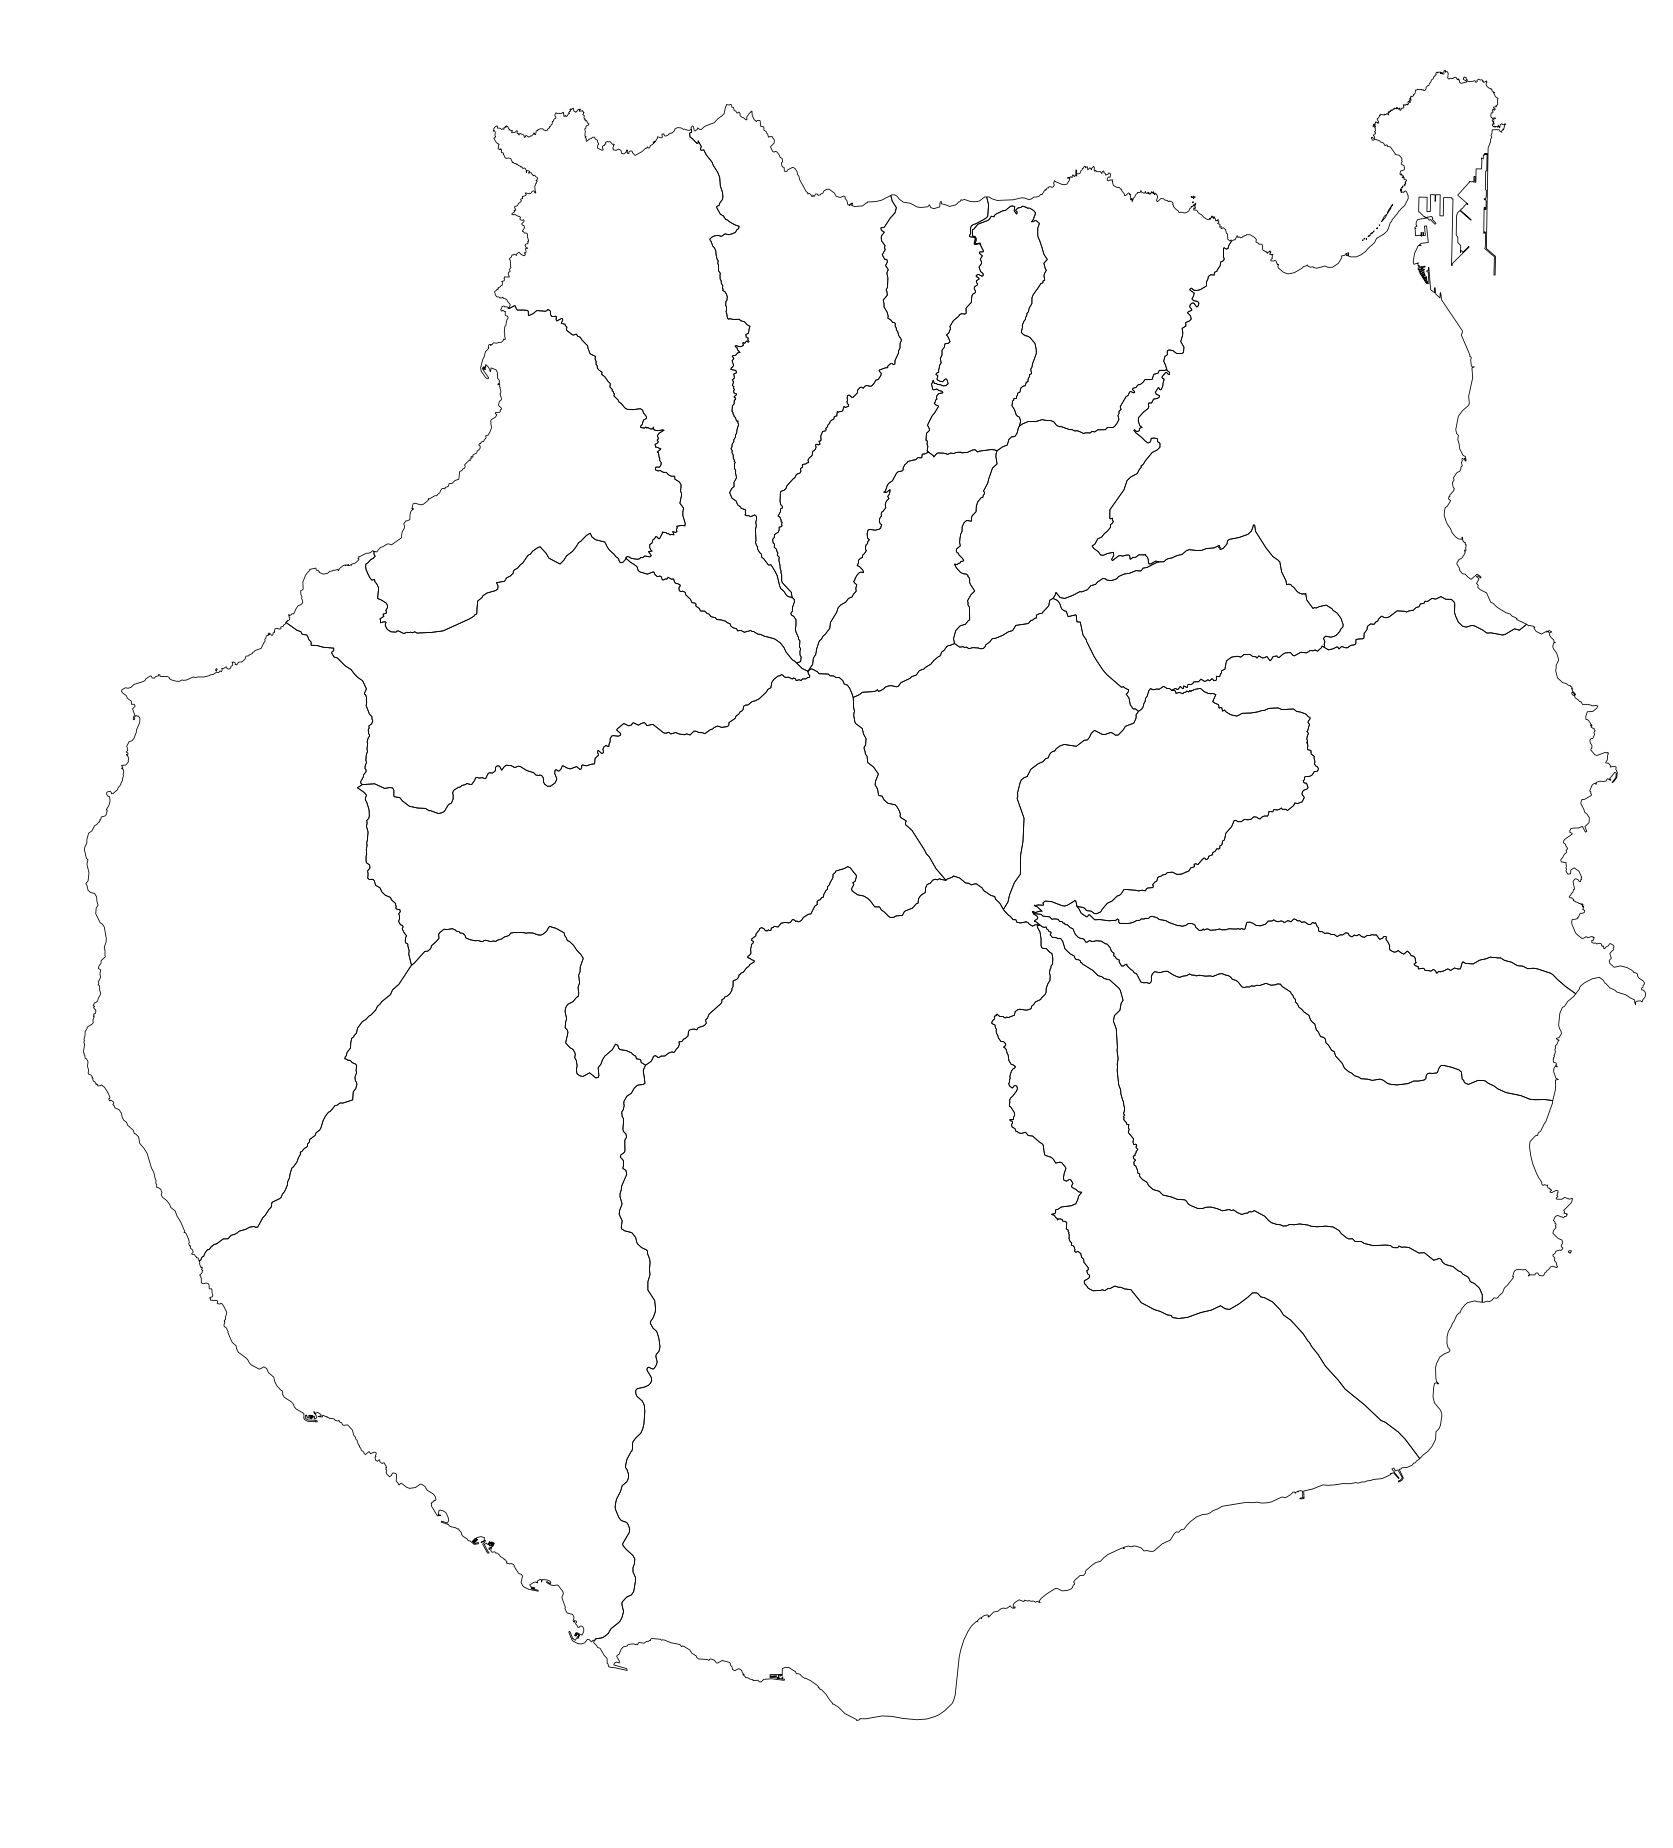

In [28]:
fig = plt.figure(frameon=False)
ax = plt.subplot(111, projection=GC.proj)
municipios.add_to_plot(ax, color="k", lw=.2)
ax.spines['geo'].set_color("w")
ax.set_extent(GC.bbox)
plt.savefig(os.path.join(figdir, "GC_municipios000.png"))
plt.show()
plt.close()

### Population map with annotations and colors
Define function to add a legend

In [29]:
def get_color_habitants_green(nhab):
    """
    Create an array of color based on the number of habitants
    """   

    if nhab > 100000:
        color = "#006837"
    elif nhab > 50000:
        color = "#31a354"
    elif nhab > 20000:
        color = "#78c679"
    elif nhab > 10000:
        color = "#addd8e"
    elif nhab > 5000:
        color = "#d9f0a3"
    else:
        color = "#ffffcc"
            
    return color

In [30]:
def get_color_habitants_red(nhab):
    """
    Create an array of color based on the number of habitants
    """   
    if nhab > 100000:
        color = "#993404"
    elif nhab > 20000:
        color = "#d95f0e"
    elif nhab > 10000:
        color = "#fe9929"
    elif nhab > 5000:
        color = "#fed98e"
    else:
        color = "#ffffd4"
            
    return color

In [31]:
def get_color_habitants_green2(nhab):
    """
    Create an array of color based on the number of habitants
    """   
    
    colorlist = ["#ffffcc", "#c2e699", "#78c679", "#31a354", "#006837"]

    if nhab > 100000:
        color = colorlist[-1]
    elif nhab > 20000:
        color = colorlist[3]
    elif nhab > 10000:
        color = colorlist[2]
    elif nhab > 5000:
        color = colorlist[1]
    else:
        color = colorlist[0]
            
    return color

In [63]:
def add_legend(colordict, ax, loc=2, ncol=2, legtitle=None):
    """Add a legend on the current ax using the color dictionary,
    which related a text and a color.
    
    ## Example
    
    colordict = {"< 1%": "#ffffe5",
             "1-5%": "#f7fcb9",
             "5-10%": "#d9f0a3",
             "10-15%": "#addd8e",
             "15-20%": "#78c679",
             "20-30%": "#41ab5d",
             "30-40%": "#238443",
             "> 40%": "#005a32"
            }
    """
    for k, v in colordict.items():
        ax.plot(0., 0., "s", color=v, markersize=7, label=k)
    leg = plt.legend(loc=loc, fontsize=8, edgecolor="w", ncol=ncol)
    if legtitle is not None:
        leg.set_title(legtitle, prop={'size': 10})

### Dictionary with the colors

In [33]:
colorhabitantdict = {"< 5000": "#ffffcc",
             "5000-10000": "#d9f0a3",
             "10000-20000": "#addd8e",
             "20000-50000": "#78c679",
             "50000-100000": "#31a354",
             "> 1000000": "#006837",
            }

colorlist = ["#ffffd4", "#fed98e", "#fe9929", "#d95f0e", "#993404"]
colorlist = ["#ffffcc", "#c2e699", "#78c679", "#31a354", "#006837"]
hablist = ["< 5000", "5000-10000", "10000-20000", "20000-100000", "> 100000"]
colorhabitantdict = dict()
for kk, vv in zip(hablist, colorlist):
    colorhabitantdict[kk] = vv
colorhabitantdict

{'< 5000': '#ffffcc',
 '5000-10000': '#c2e699',
 '10000-20000': '#78c679',
 '20000-100000': '#31a354',
 '> 100000': '#006837'}

In [48]:
for municipios in datamun["features"]:
    
    # Check if in Gran Canaria ('ES705 as CODNUT3')
    if municipios["properties"]["CODNUT3"] == 'ES705':
        name = municipios['properties']['NAMEUNIT']
        logger.info("Working on {}".format(name))
        nhab = properties["Population"][name]
        logger.info(properties["Population"][name])

INFO:populationCanary:Working on Agaete
INFO:populationCanary:5633
INFO:populationCanary:Working on Agüimes
INFO:populationCanary:32067
INFO:populationCanary:Working on Artenara
INFO:populationCanary:1030
INFO:populationCanary:Working on Arucas
INFO:populationCanary:38369
INFO:populationCanary:Working on Firgas
INFO:populationCanary:7581
INFO:populationCanary:Working on Gáldar
INFO:populationCanary:24567
INFO:populationCanary:Working on Ingenio
INFO:populationCanary:31932
INFO:populationCanary:Working on Mogán
INFO:populationCanary:20331
INFO:populationCanary:Working on Moya
INFO:populationCanary:7870
INFO:populationCanary:Working on Las Palmas de Gran Canaria
INFO:populationCanary:378797
INFO:populationCanary:Working on San Bartolomé de Tirajana
INFO:populationCanary:52936
INFO:populationCanary:Working on La Aldea de San Nicolás
INFO:populationCanary:7536
INFO:populationCanary:Working on Santa Brígida
INFO:populationCanary:18341
INFO:populationCanary:Working on Santa Lucía de Tirajana

INFO:populationCanary:Number of habitants in Agaete: 5633 (5558)
/tmp/ipykernel_19295/488622798.py:40: MatplotlibDeprecationWarning: Passing the closed parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  polygon = Polygon(c2, True)
INFO:populationCanary:Number of habitants in Agüimes: 32067 (30742)
INFO:populationCanary:Number of habitants in Artenara: 1030 (1136)
INFO:populationCanary:Number of habitants in Arucas: 38369 (37299)
INFO:populationCanary:Number of habitants in Firgas: 7581 (7465)
INFO:populationCanary:Number of habitants in Gáldar: 24567 (24296)
INFO:populationCanary:Number of habitants in Ingenio: 31932 (30340)
INFO:populationCanary:Number of habitants in Mogán: 20331 (21049)
INFO:populationCanary:Number of habitants in Moya: 7870 (7821)
INFO:populationCanary:Number of habitants in Las Palmas de Gran Canaria: 378797 (378998)
INFO:populationCanary:Number of habitants in San Bartolomé d

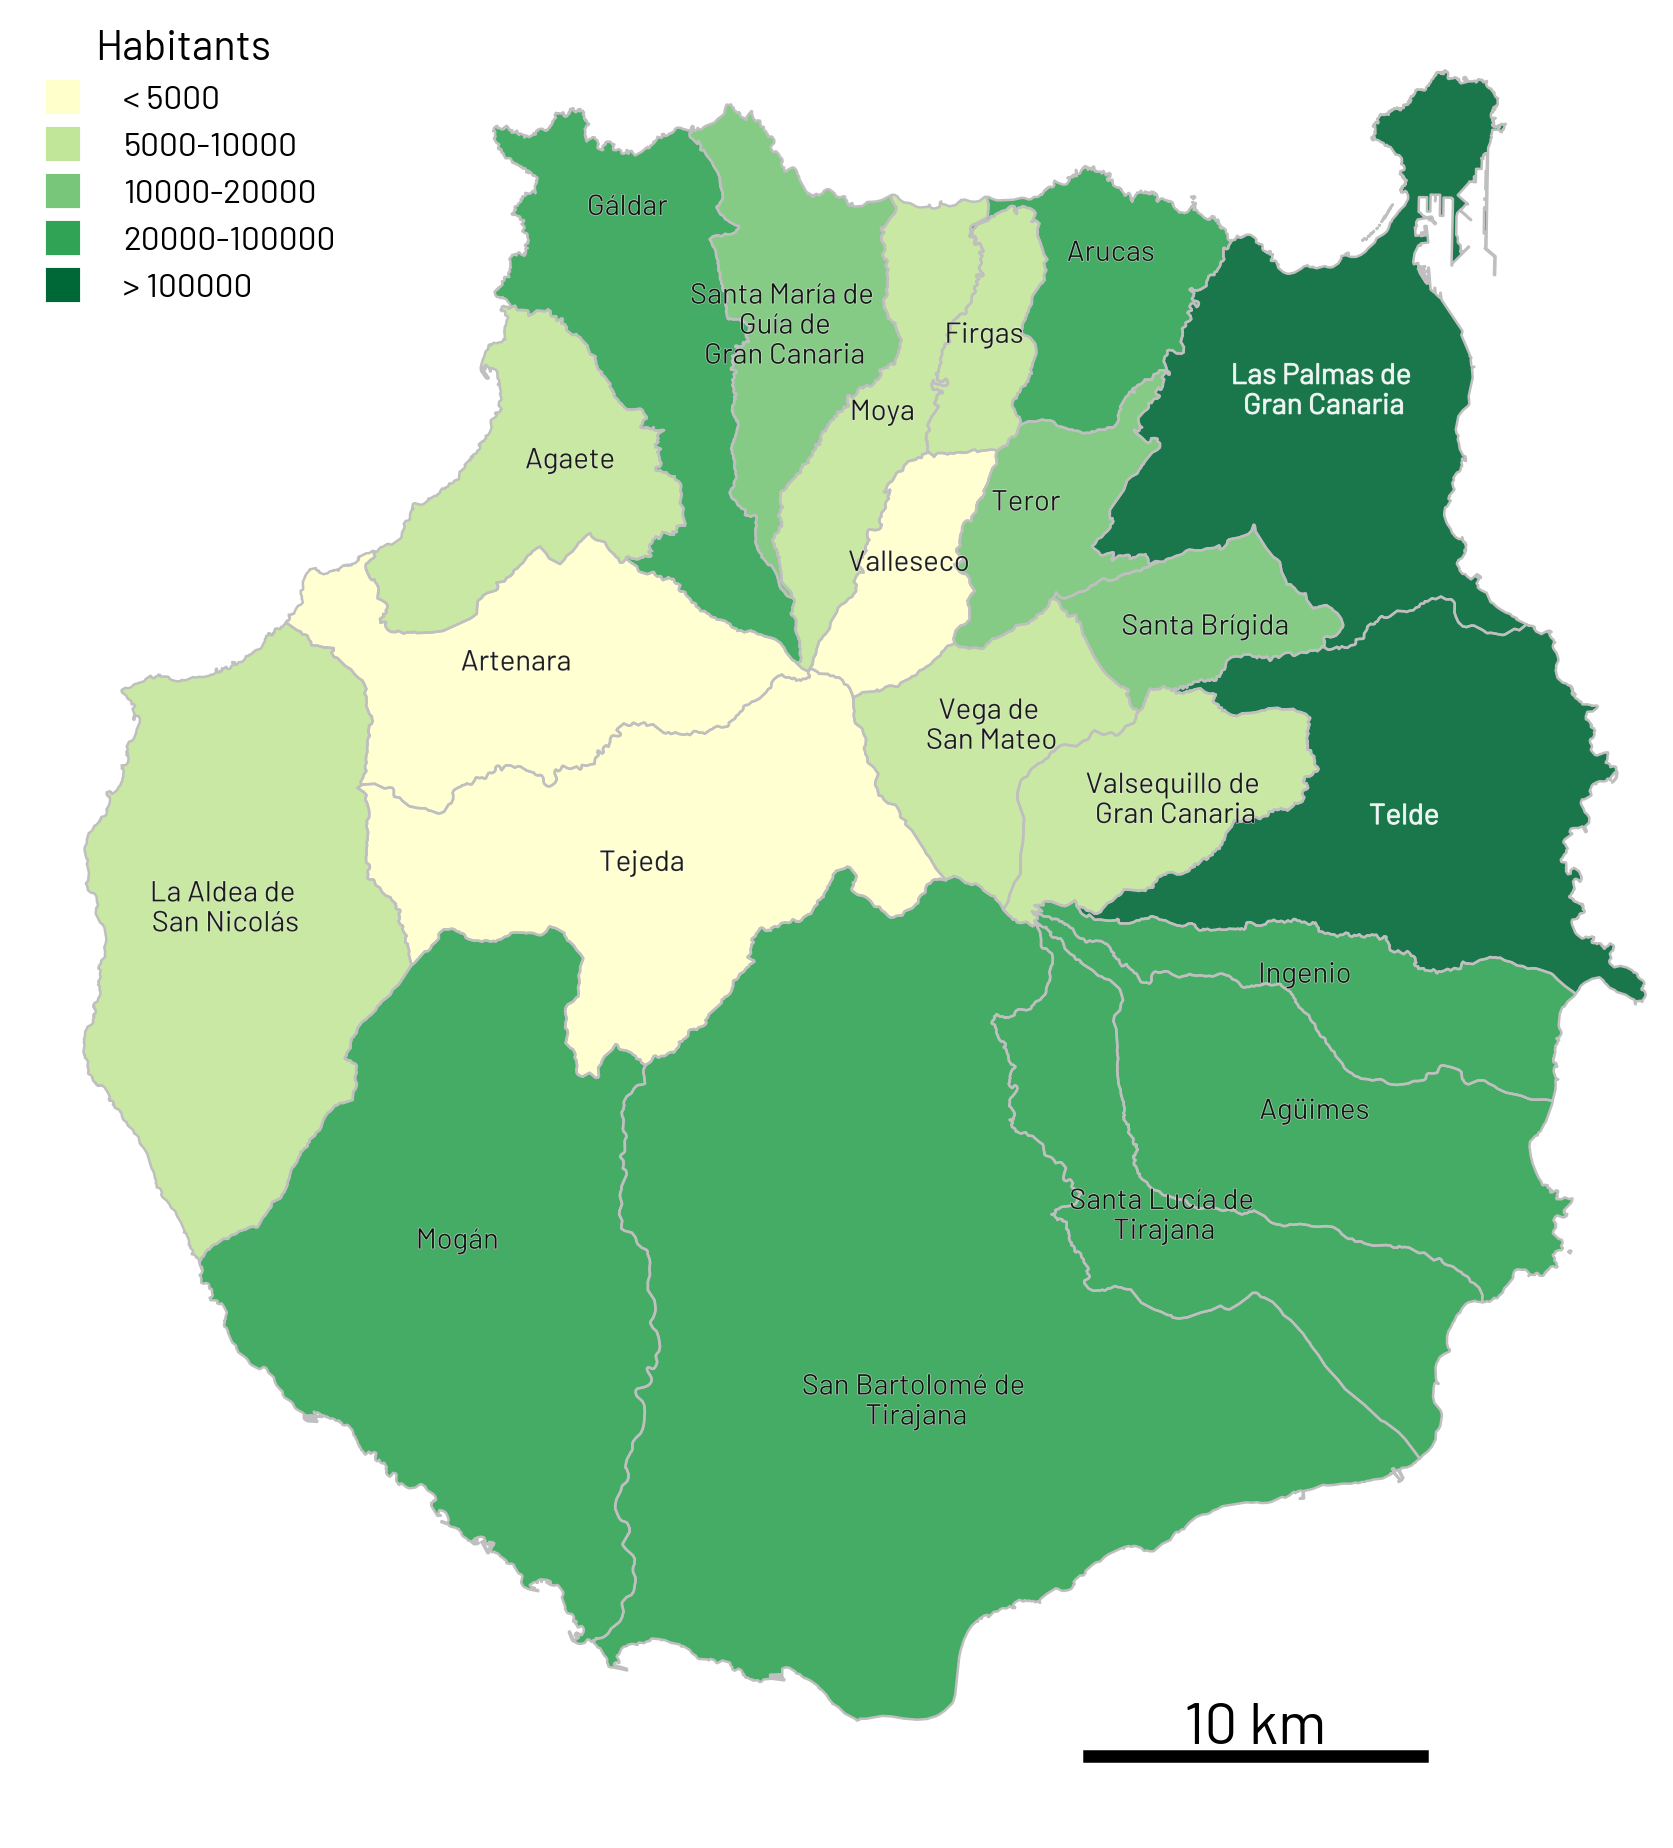

In [41]:
patches = []
nhabitants = []
colorlist = []

listdown = ["Las Palmas de Gran Canaria", "San Bartolomé de Tirajana"]
listmiddown = ["Santa Lucía de Tirajana"]
listup = ["Gáldar", "Mogán"]
listright = ["Agaete"]
listleft = ["Teror", "Las Palmas de Gran Canaria"]

fig = plt.figure(frameon=False)
ax = plt.subplot(111, projection=GC.proj)
ax.set_extent(GC.bbox)

for municipios in datamun["features"]:
    
    # Check if in Gran Canaria ('ES705 as CODNUT3')
    if municipios["properties"]["CODNUT3"] == 'ES705':
        name = municipios['properties']['NAMEUNIT']
        logger.debug("Working on {}".format(name))

        # Get the number of habitants
        nhab0 = int(municipios['properties']['hab'])
        nhab = properties["Population"][name]
        nhabitants.append(nhab)
        logger.debug(f"Number of habitants in {name}: {nhab} ({nhab0})")

        # Get color from number of habitants
        color = get_color_habitants_green2(nhab0)

        # Get the coordinates
        coords = municipios['geometry']['coordinates']

        lonall, latall = [], []
        for c1 in coords:
            lon = []
            lat = []
            for c2 in c1:
                # cproj = [[m(c3[0], c3[1])[0], m(c3[0], c3[1])[1]] for c3 in c2]
                polygon = Polygon(c2, True)
                patches.append(polygon)
                colorlist.append(color)
                for c3 in c2:
                    lon.append(c3[0])
                    lat.append(c3[1])
            lonall.extend(lon)
            latall.extend(lat)
            ax.plot(lon, lat, color='.75', linewidth=.6, zorder=2, transform=hikinggc.data_crs)
            # ax.plot(lon, lat, color='k', linewidth=.2, zorder=3, transform=hikinggc.data_crs)
        lonmean = np.array(lonall).mean()
        latmean = np.array(latall).mean()


        if name in listdown:
            lattex = latmean - .025
        elif name in listmiddown:
            lattex = latmean - 0.0125
        elif name in listup:
            lattex = latmean + .0275
        else:
            lattex = latmean

        if name in listleft:
            lontex = lonmean - .015
        elif name in listright:
            lontex = lonmean + 0.0125
        else:
            lontex = lonmean

        if nhab > 100000:
            textcolor = "w"
        else:
            textcolor = "k"
            
        text = ax.text(lontex, lattex, name.replace(" de"," de\n"), 
                 color=textcolor, ha='center', va="center", alpha=.7,
                 fontsize=7, transform=hikinggc.data_crs)
        text.set_path_effects([path_effects.Stroke(linewidth=.25, foreground='white'),
                           path_effects.Normal()])
        
# Define colors
nhabitants = np.array(nhabitants)
p = PatchCollection(patches, alpha=.9, transform=hikinggc.data_crs)
p.set_facecolors(colorlist)
ax.add_collection(p)

add_legend(colorhabitantdict, ax, loc=2, ncol=1, legtitle="Habitants")

ax.spines['geo'].set_color("w")
hikinggc.scale_bar(ax, myproj=GC.proj, length=None, location=(0.75, 0.05), linewidth=3, fs=14)

plt.savefig(os.path.join(figdir, "GC_habitants000"))

plt.show()
plt.close()

### With numbers

/tmp/ipykernel_19295/986412161.py:37: MatplotlibDeprecationWarning: Passing the closed parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  polygon = Polygon(c2, True)


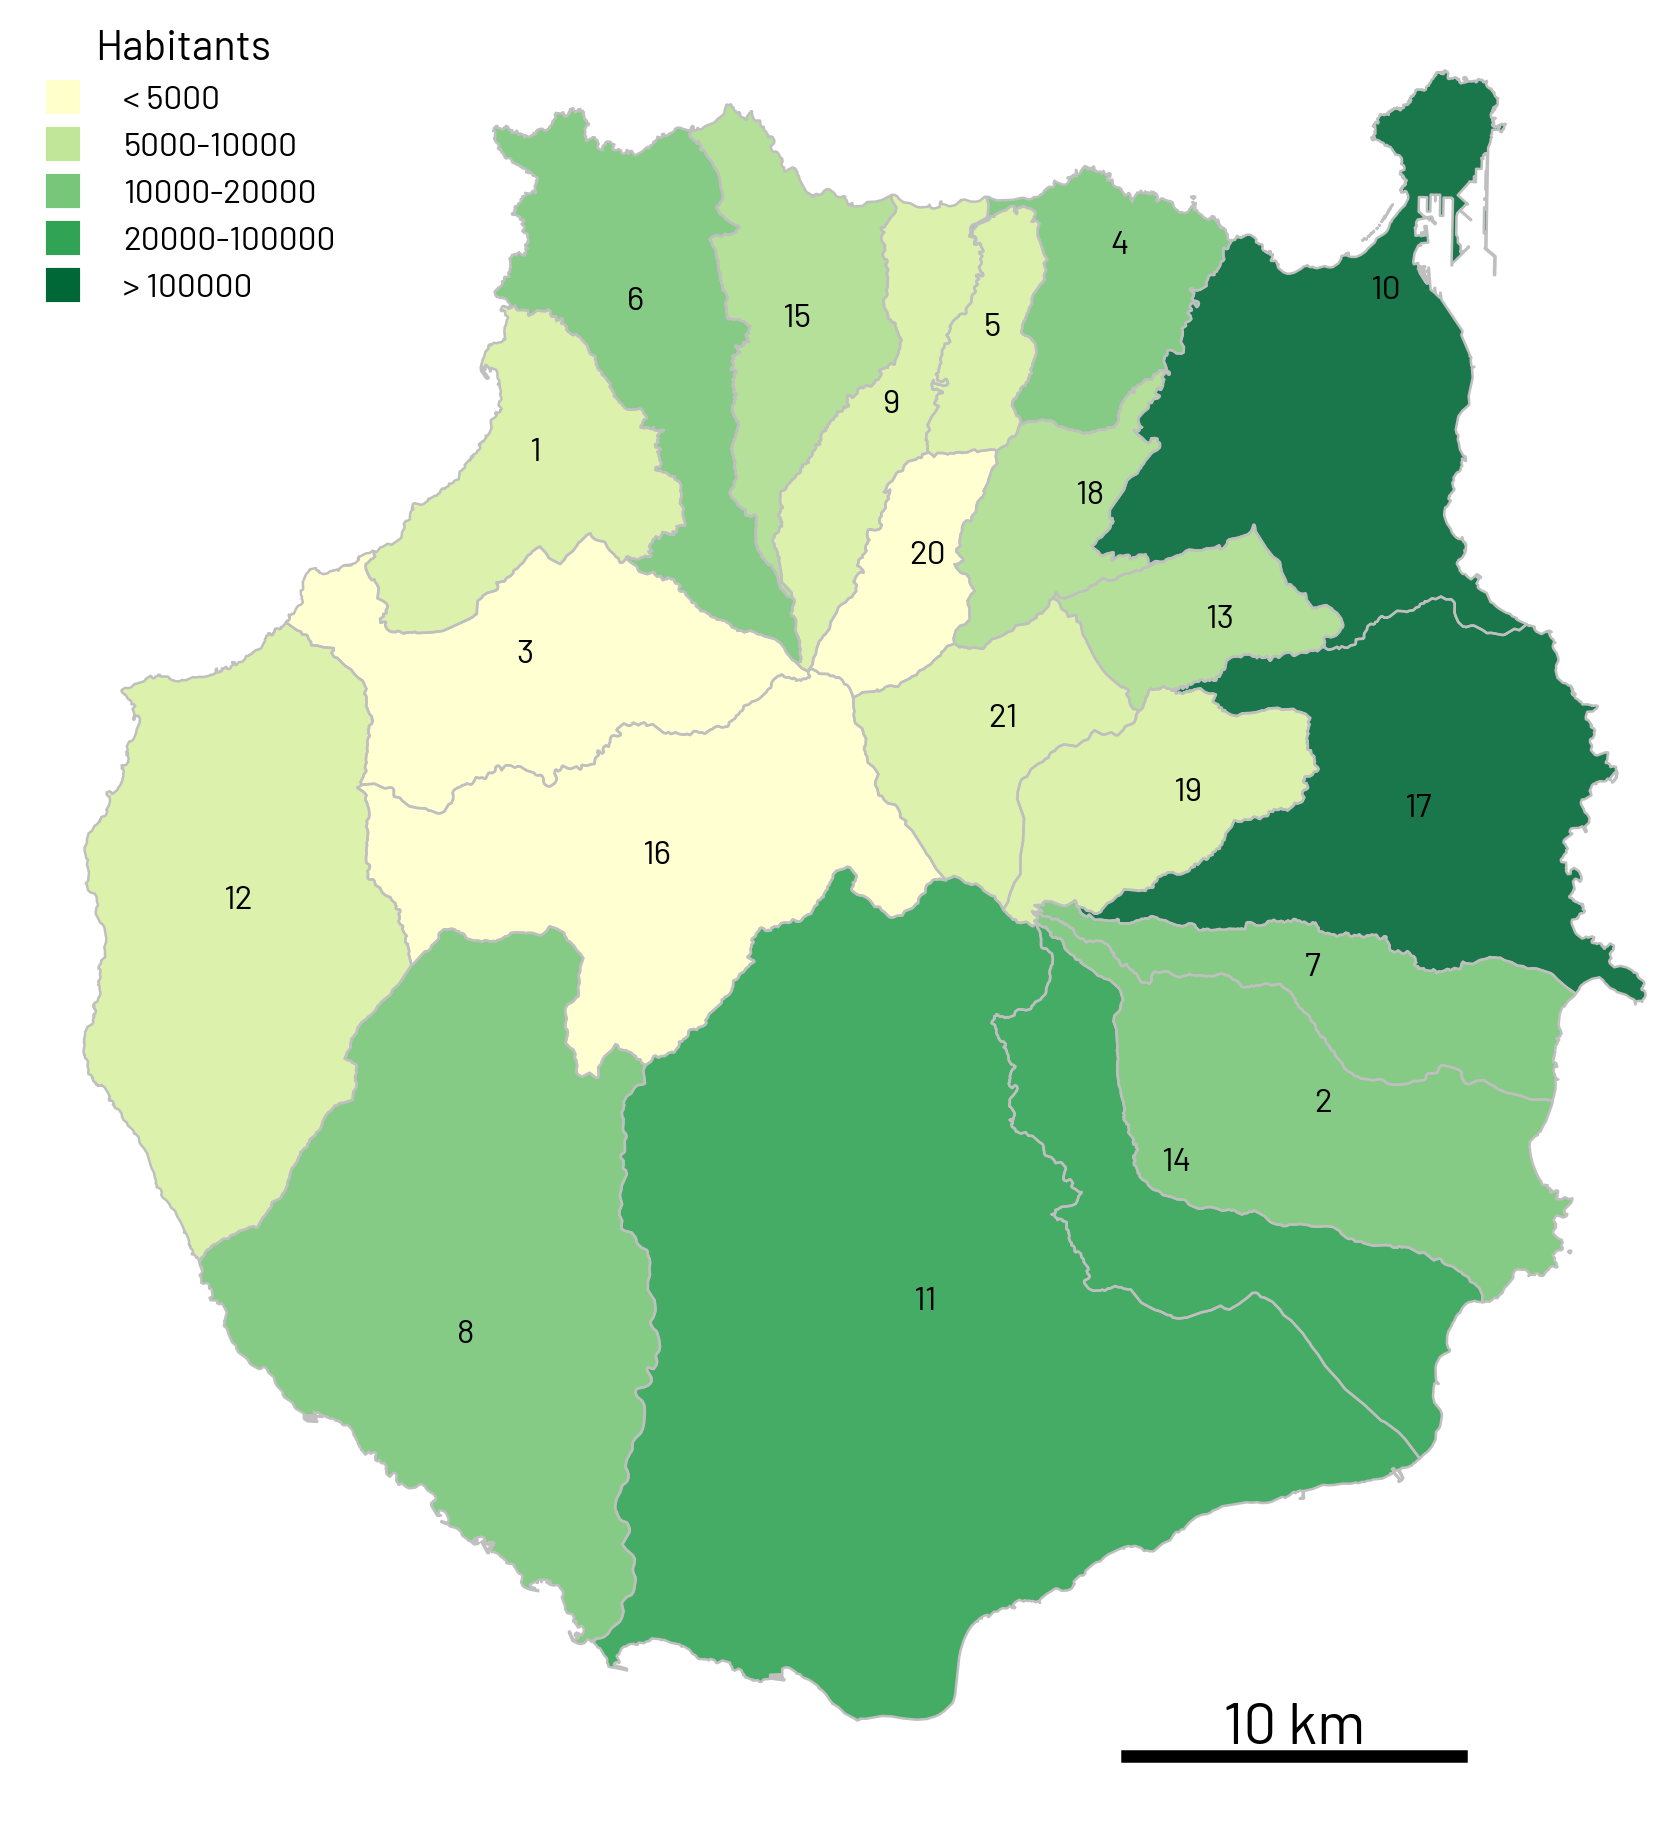

In [43]:
patches = []
nhabitants = []
colorlist = []

listdown = ["Las Palmas de Gran Canaria", "San Bartolomé de Tirajana"]
listmiddown = ["Santa Lucía de Tirajana"]
listup = ["Gáldar", "Valsquillo de Gran Canaria", "Mogán"]
listright = ["Agaete"]
listleft = ["Teror", "Las Palmas de Gran Canaria"]

fig = plt.figure(frameon=False)
ax = plt.subplot(111, projection=GC.proj)

for iii, municipios in enumerate(datamun["features"]):
    
    # Check if in Gran Canaria
    name = municipios['properties']['NAMEUNIT']
    logger.debug("Working on {}".format(name))

    # Get the number of habitants
    nhab = int(municipios['properties']['hab'])
    nhabitants.append(nhab)
    logger.debug(f"Number of habitants in {name}: {nhab}")

    # Get color from number of habitants
    color = get_color_habitants_green(nhab)

    # Get the coordinates
    coords = municipios['geometry']['coordinates']

    lonall, latall = [], []
    for c1 in coords:
        lon = []
        lat = []
        for c2 in c1:
            # cproj = [[m(c3[0], c3[1])[0], m(c3[0], c3[1])[1]] for c3 in c2]
            polygon = Polygon(c2, True)
            patches.append(polygon)
            colorlist.append(color)
            for c3 in c2:
                lon.append(c3[0])
                lat.append(c3[1])
        lonall.extend(lon)
        latall.extend(lat)
        ax.plot(lon, lat, color='.75', linewidth=.6, zorder=2, transform=hikinggc.data_crs)
        #ax.plot(lon, lat, color='k', linewidth=.2, zorder=3, transform=hikinggc.data_crs)
    lonmean = np.array(lonall).mean()
    latmean = np.array(latall).mean()

    ax.text(lonmean, latmean, str(iii+1), transform=hikinggc.data_crs)
        
# Define colors
nhabitants = np.array(nhabitants)
p = PatchCollection(patches, alpha=.9, transform=hikinggc.data_crs)
p.set_facecolors(colorlist)
ax.add_collection(p)

add_legend(colorhabitantdict, ax, loc=2, ncol=1, legtitle="Habitants")

ax.spines['geo'].set_color("w")
hikinggc.scale_bar(ax, myproj=GC.proj, length=None, location=(0.75, 0.05), linewidth=3, fs=14)
ax.set_extent(GC.bbox)

plt.savefig(os.path.join(figdir, "GC_habitants001"))

plt.show()
plt.close()

### Density

In [51]:
def get_color_density(dens):
    """
    Create an array of color based on the number of habitants
    """   

    if dens > 1000:
        color = "#006837"
    elif dens > 500:
        color = "#31a354"
    elif dens > 250:
        color = "#78c679"
    elif dens > 100:
        color = "#c2e699"
    else:
        color = "#ffffcc"
            
    return color

densitydict = {"< 100": "#ffffcc",
             "100-250": "#c2e699",
             "250-500": "#78c679",
             "500-1000": "#31a354",
             "> 1000": "#006837",
            }

In [59]:
patches = []
densities = []
colorlist = []

fig = plt.figure(frameon=False)
ax = plt.subplot(111, projection=GC.proj)

for municipios in datamun["features"]:
    
    name = municipios['properties']['NAMEUNIT']

    # Get the coordinates
    coords = municipios['geometry']['coordinates']

    lonall, latall = [], []

    dens = properties["Population"][name] / properties["Surface"][name]
    densities.append(dens)
    color = get_color_density(dens)
    
    for c1 in coords:
        lon = []
        lat = []
        for c2 in c1:
            # cproj = [[m(c3[0], c3[1])[0], m(c3[0], c3[1])[1]] for c3 in c2]
            polygon = Polygon(c2, True)
            pol = shapely.Polygon(c2)
            totalsurf += pol.area
            patches.append(polygon)
            colorlist.append(color)
            for c3 in c2:
                lon.append(c3[0])
                lat.append(c3[1])
        lonall.extend(lon)
        latall.extend(lat)
        ax.plot(lon, lat, color='.75', linewidth=.6, zorder=2, transform=hikinggc.data_crs)
        # ax.plot(lon, lat, color='k', linewidth=.2, zorder=3, transform=hikinggc.data_crs)

# Define colors
densities = np.array(densities)
p = PatchCollection(patches, alpha=.9, transform=hikinggc.data_crs)
p.set_facecolors(colorlist)
ax.add_collection(p)

add_legend(densitydict, ax, loc=2, ncol=1, legtitle="Densité de population\n(hab./km²)")

ax.spines['geo'].set_color("w")
hikinggc.scale_bar(ax, myproj=GC.proj, length=None, location=(0.75, 0.05), linewidth=3, fs=14)
ax.set_extent(GC.bbox)

#plt.savefig(os.path.join(figdir, "GC_density.png"))

plt.show()
plt.close()

/tmp/ipykernel_19295/3593542224.py:26: MatplotlibDeprecationWarning: Passing the closed parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  polygon = Polygon(c2, True)


## Relative population by island
Need 
- the contours of all the municipalies ([geoJSON file](https://datos.canarias.es/catalogos/estadisticas/dataset/municipios-canarias-2007-delimitaciones-territoriales-fines-estadisticos/resource/812f22ae-62a5-4cea-8052-b0269b1bd491));
- the population of all the minicipalities.

In [82]:
datafilecanarias = os.path.join(hikinggc.datadir, "CanariasMunicipios2.geojson")
datafilelistpop = glob.glob(os.path.join(hikinggc.datadir, "Population/*.csv"))
datafilelistpop

['../Data/Population/tenerife.csv',
 '../Data/Population/grancanaria.csv',
 '../Data/Population/elhierro.csv',
 '../Data/Population/lagomera.csv',
 '../Data/Population/lapalma.csv',
 '../Data/Population/lanzarote.csv',
 '../Data/Population/fuerteventuta.csv']

In [83]:
with open(datafilecanarias, "r") as df:
    municipioscan = json.load(df)

In [37]:
population_municipio = dict()
for datafilepop in datafilelistpop:
    logger.debug(datafilepop)
    with open(datafilepop, "r") as df:
        firstline = df.readline().rstrip()
        islandname = firstline.split(",")[0]
        totalhabitants = int(firstline.split(",")[1])
        logger.info(f"{islandname}: {totalhabitants} habitants")
        for lines in df.readlines():
            theline = lines.rstrip()
            municipioname = theline.split(",")[0]
            relativepopulation = int(theline.split(",")[1]) / totalhabitants
            logger.debug(f"{municipioname}: {relativepopulation}%")
            population_municipio[municipioname] = relativepopulation

INFO:populationCanary:Tenerife: 931646 habitants
INFO:populationCanary:Gran Canaria: 853262 habitants
INFO:populationCanary:El Hierro: 11423 habitants
INFO:populationCanary:La Gomera: 21798 habitants
INFO:populationCanary:La Palma: 83439 habitants
INFO:populationCanary:Lanzarote: 156112 habitants
INFO:populationCanary:Fuerteventura: 120021 habitants


### Histogram of the relative population

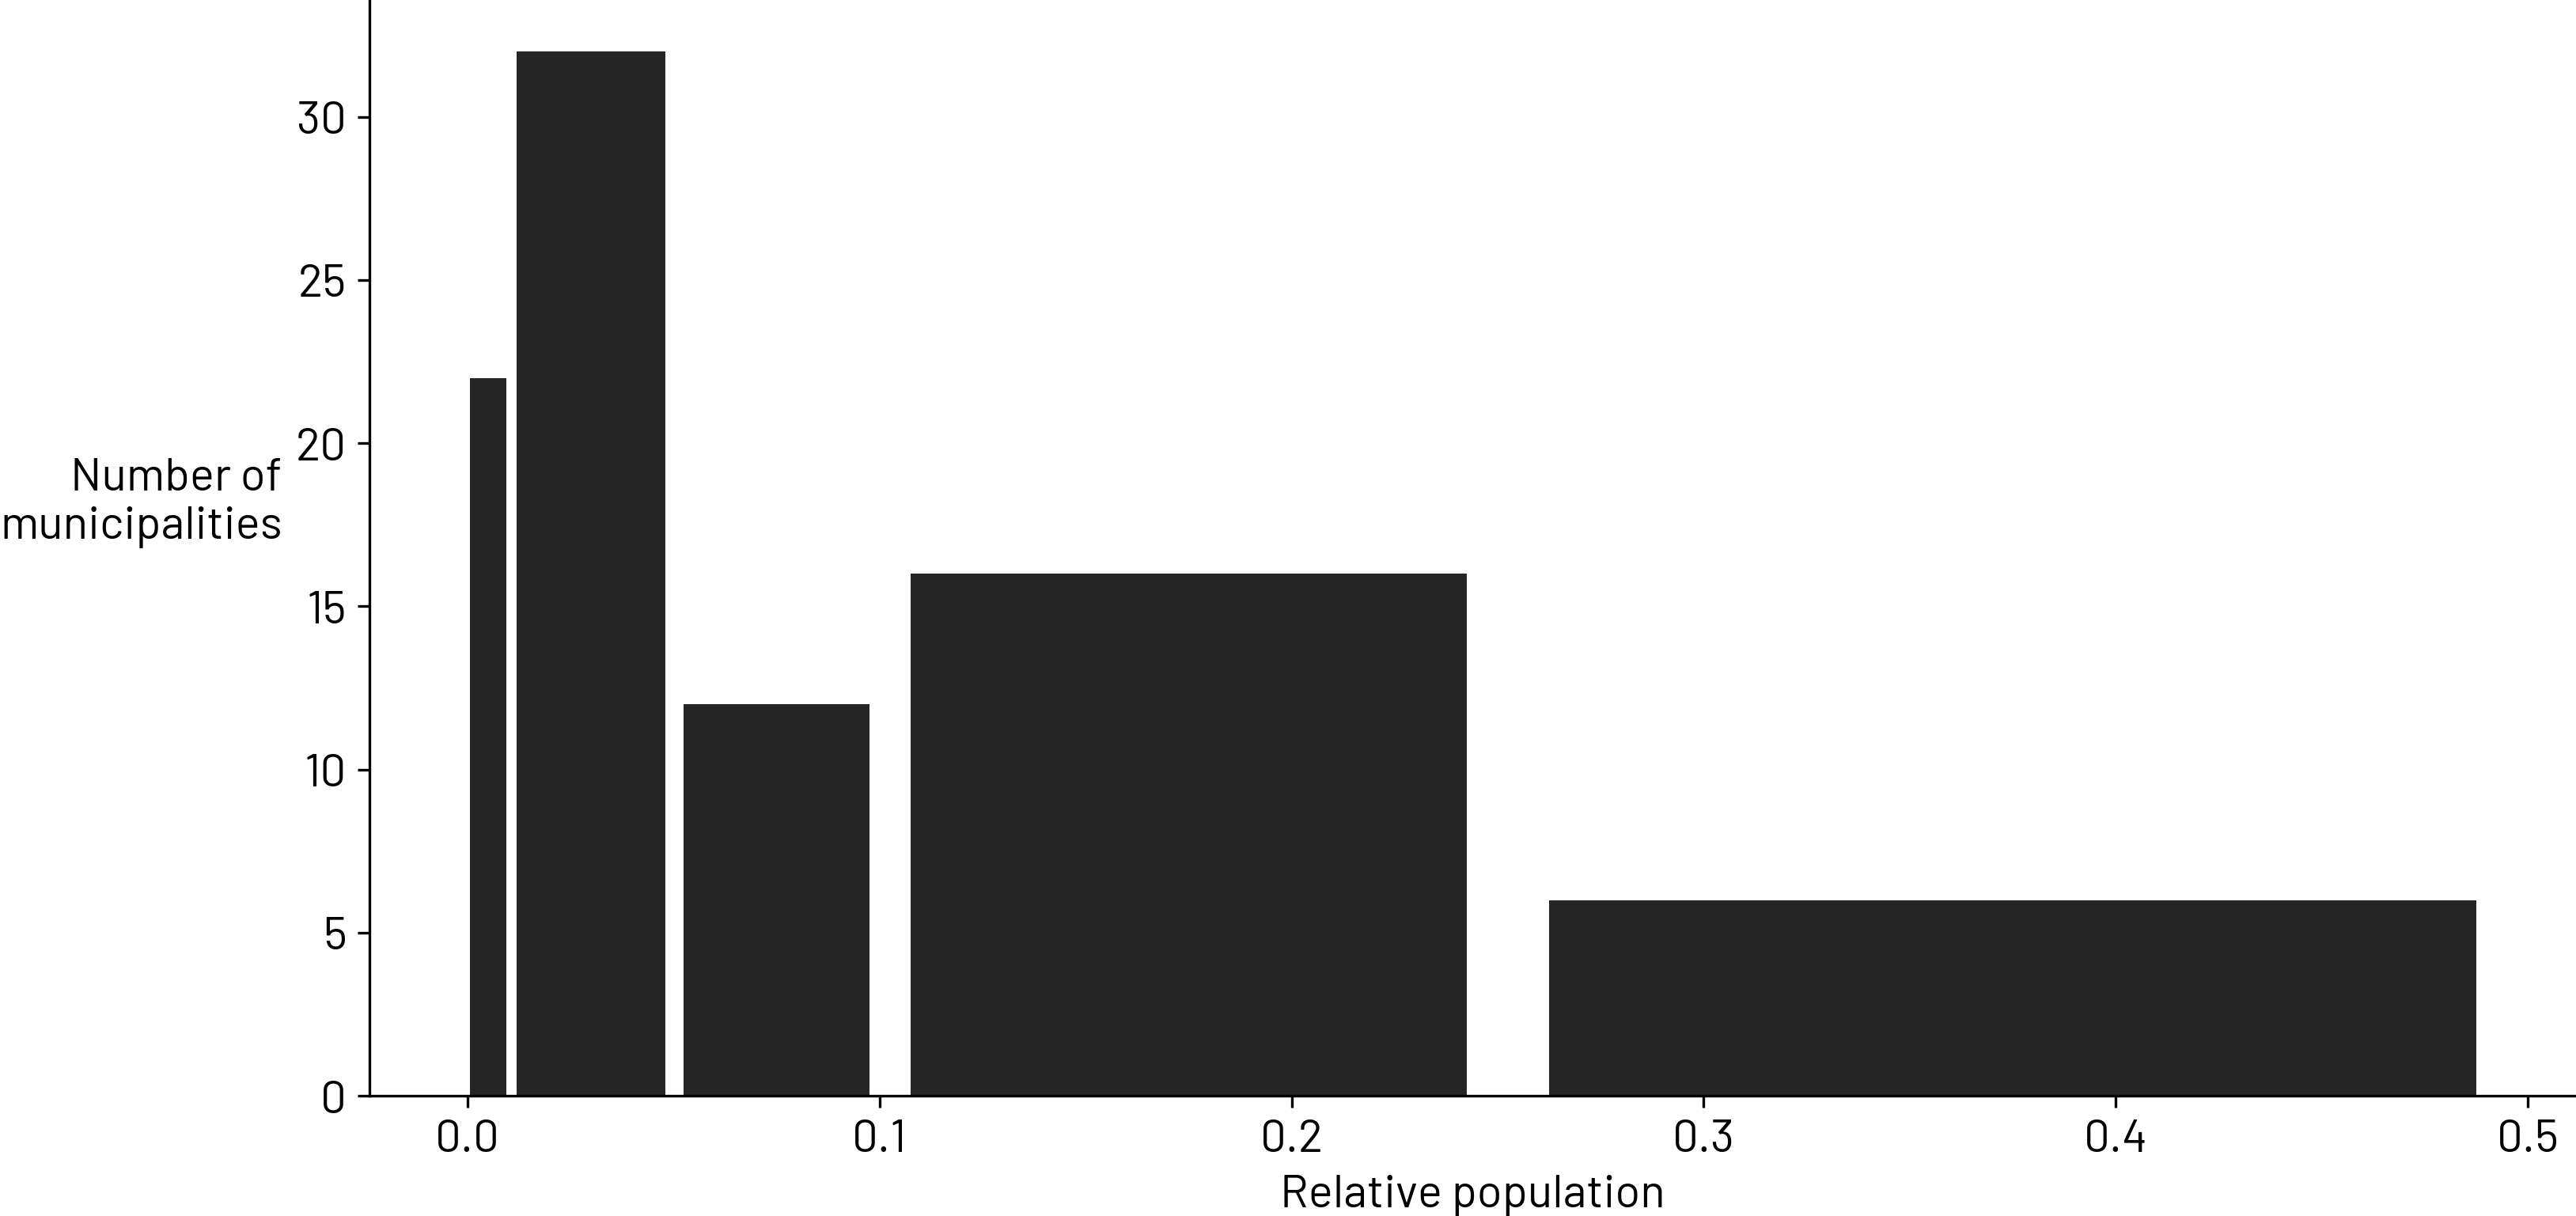

In [42]:
fig = plt.figure(figsize=(12, 6))
ax = plt.subplot(111)
valbins = [0.00, 0.01, 0.05, 0.1, 0.25, 0.5]
ax.hist(population_municipio.values(), bins=valbins, rwidth=.9, color=".15")
ax.set_xlabel("Relative population")
ax.set_ylabel("Number of\nmunicipalities", rotation=0, ha="right")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [ ]:
def get_color_rel_pop(nhab, colorlist=["#ffffe5", "#f7fcb9", "#d9f0a3", "#addd8e", "#78c679",
                                       "#41ab5d", "#238443", "#005a32"]):
    """
    Create an array of color based on the number of habitants
    """   
    #colorlistredblue = ["#053061", "#2F79B5", "#84BCD9", "#DBEAF2", 
    #                    "#FBE4D6", "#F09C7B", "#C2383A", "#67001F" ]
    
    if nhab < 0.01:
        color = colorlist[0]
    elif nhab < 0.05:
        color = colorlist[1]
    elif nhab < 0.1:
        color = colorlist[2]
    elif nhab < 0.15:
        color = colorlist[3]
    elif nhab < 0.2:
        color = colorlist[4]
    elif nhab < 0.3:
        color = colorlist[5]
    elif nhab < 0.4:
        color = colorlist[6] 
    else:
        color = colorlist[7]
             
            
    return color

In [43]:
def get_color_rel_pop(nhab, colorlist=["#ffffcc", "#c2e699", "#78c679", "#31a354", "#006837"]):
    """
    Create an array of color based on the number of habitants
    """   
    
    valbins = [0.00, 0.01, 0.05, 0.1, 0.25, 0.5]
    
    if nhab < valbins[1]:
        color = colorlist[0]
    elif nhab < valbins[2]:
        color = colorlist[1]
    elif nhab < valbins[3]:
        color = colorlist[2]
    elif nhab < valbins[4]:
        color = colorlist[3]
    else:
        color = colorlist[-1]
             
            
    return color

In [44]:
colordict = {"< 1%": "#053061",
             "1-5%": "#2F79B5",
             "5-10%": "#84BCD9",
             "10-15%": "#DBEAF2",
             "15-20%": "#FBE4D6",
             "20-30%": "#F09C7B",
             "30-40%": "#C2383A",
             "> 40%": "#67001F"
            }

colordict = {"< 1%": "#ffffe5",
             "1-5%": "#f7fcb9",
             "5-10%": "#d9f0a3",
             "10-15%": "#addd8e",
             "15-20%": "#78c679",
             "20-30%": "#41ab5d",
             "30-40%": "#238443",
             "> 40%": "#005a32"
            }

colorlist = ["#ffffcc", "#c2e699", "#78c679", "#31a354", "#006837"]
colordict = {"< 1%": colorlist[0],
             "1-5%": colorlist[1],
             "5-10%": colorlist[2],
             "10-25%": colorlist[3],
             "> 25%": colorlist[4]
            }

/tmp/ipykernel_21462/746600274.py:30: MatplotlibDeprecationWarning: Passing the closed parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  polygon = Polygon(c2, True)


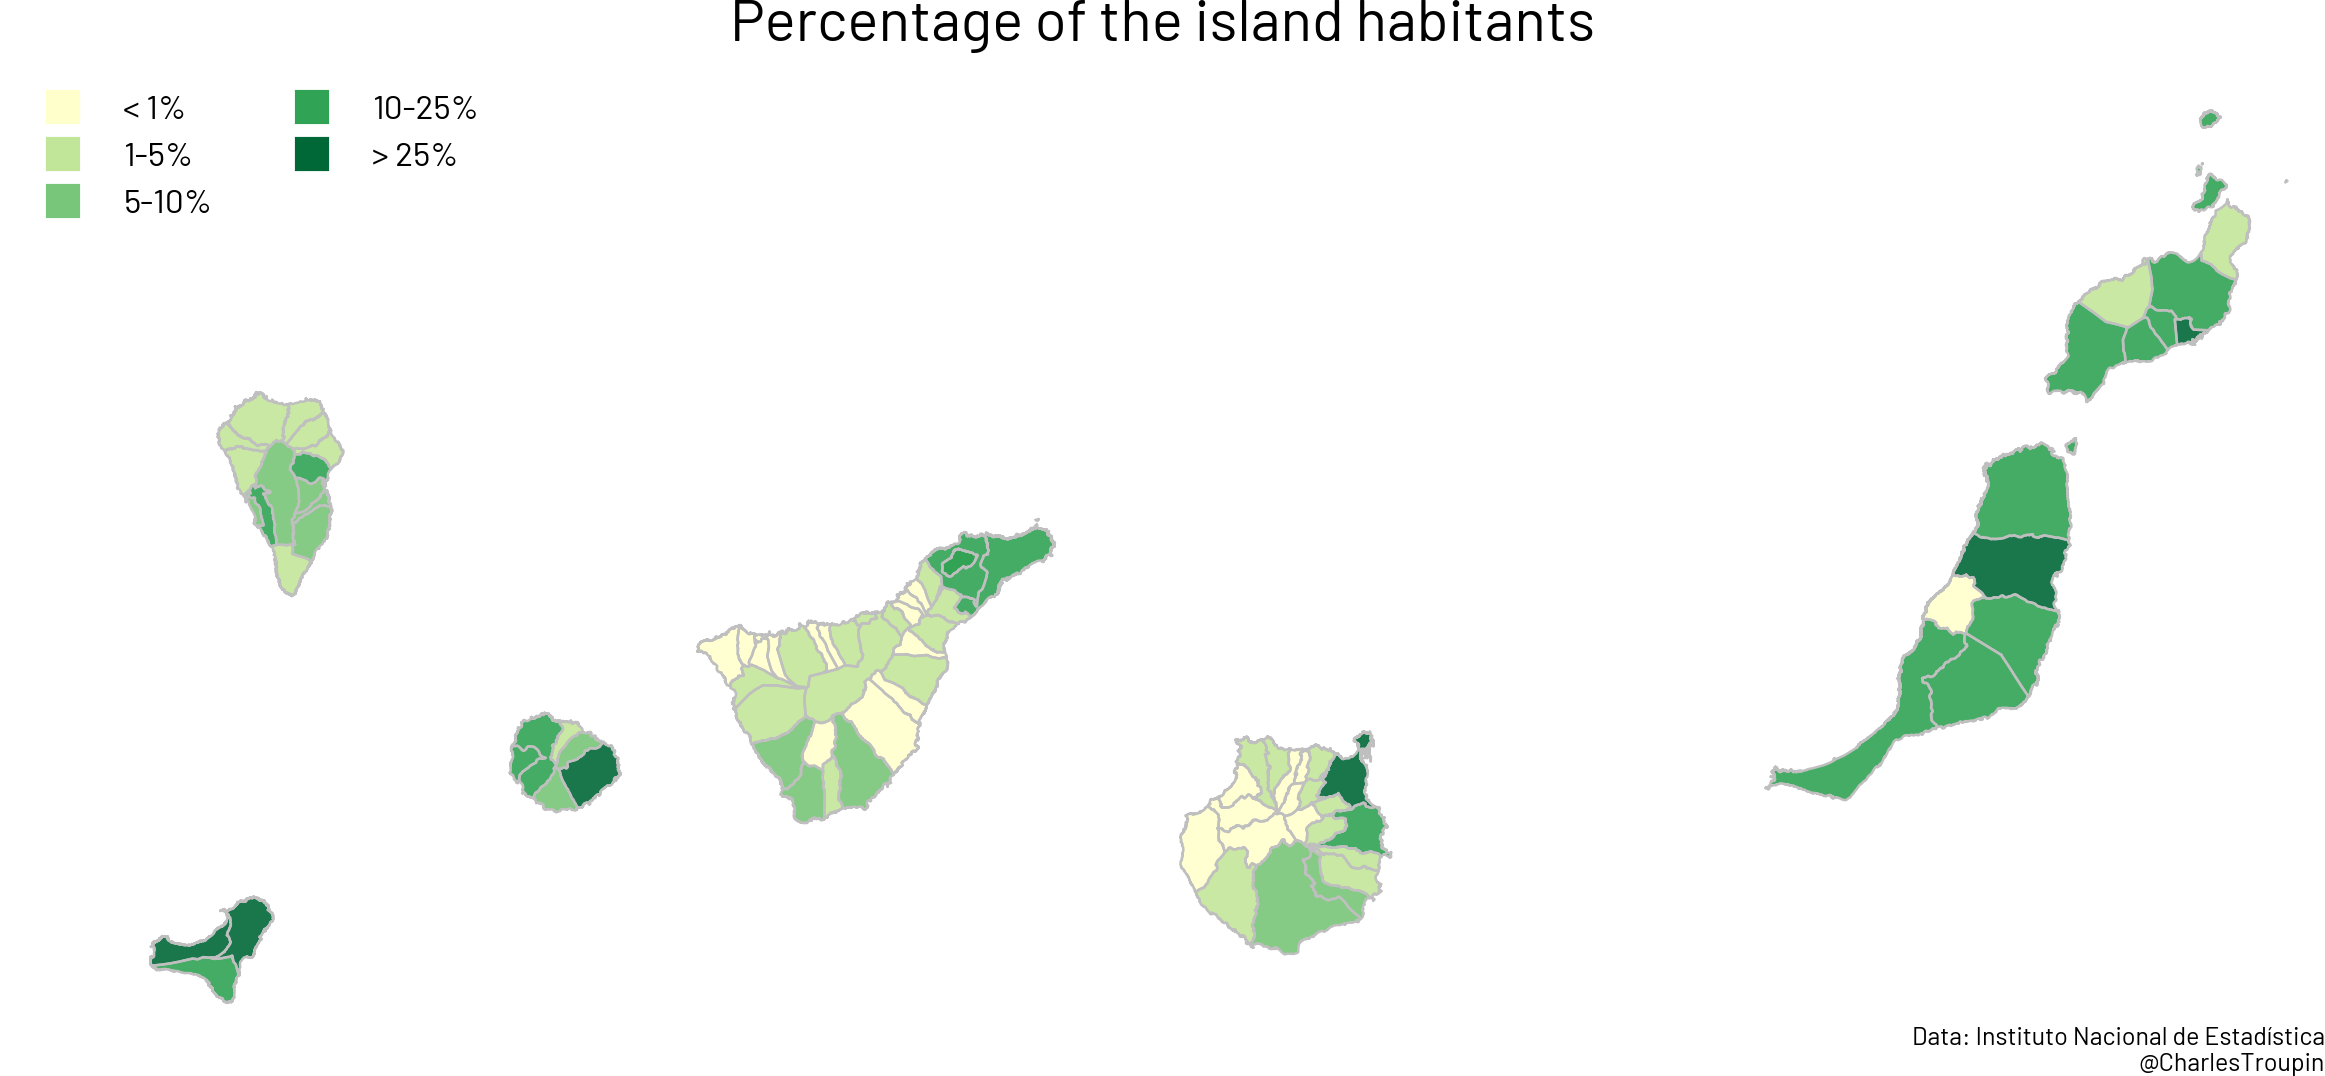

In [140]:
IC = hikinggc.Island(bbox=hikinggc.iccoords)
patches = []
nhabitants = []
colorlist = []
cmap = plt.cm.RdBu_r

fig = plt.figure(frameon=False)
ax = plt.subplot(111, projection=IC.proj)

for municipios in municipioscan["features"]:
    
    #municipioname = municipios['properties']['etiqueta']
    municipiocode = int(municipios["properties"]["codmun"])
    municipioname = code_municipio_dict[municipiocode]
    #logger.info("Working on {}".format(municipioname))

    # Get the number of habitants
    nhab = population_municipio[municipioname]

    # Get color from number of habitants
    color = get_color_rel_pop(nhab)

    # Get the coordinates
    coords = municipios['geometry']['coordinates']

    for c1 in coords:
       
        for c2 in c1:
            # cproj = [[m(c3[0], c3[1])[0], m(c3[0], c3[1])[1]] for c3 in c2]
            polygon = Polygon(c2, True)
            patches.append(polygon)
            colorlist.append(color)
            lon = []
            lat = [] 
            for c3 in c2:
                lon.append(c3[0])
                lat.append(c3[1])
            lonall.extend(lon)
            latall.extend(lat)
            ax.plot(lon, lat, color='.75', linewidth=.6, zorder=2, transform=hikinggc.data_crs)

        
# Define colors
nhabitants = np.array(nhab)
p = PatchCollection(patches, alpha=.9, transform=hikinggc.data_crs)
p.set_facecolors(colorlist)
ax.add_collection(p)
ax.text(IC.bbox[1], IC.bbox[2], "Data: Instituto Nacional de Estadística\n@CharlesTroupin", 
        va="bottom", ha="right", transform=hikinggc.data_crs, fontsize=6)

bins = 100 * np.array(valbins)
norm = BoundaryNorm(bins, cmap.N)

ax.set_title("Percentage of the island habitants", fontsize=14)

add_legend(colordict, ax)

ax.spines['geo'].set_color("w")
#hikinggc.scale_bar(ax, myproj=GC.proj, length=None, location=(0.75, 0.05), linewidth=3, fs=14)
ax.set_extent(hikinggc.iccoords)


plt.savefig(os.path.join(figdir, "canarias_habitants6.png"))

plt.show()
plt.close()